In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
RCS_original= np.array([[-1, -0.987063428, -0.974129442, -0.961198042, -0.948269226, -0.935342994, -0.922419344, -0.909498275, -0.896579787, -0.870750547, -0.735315981, -0.664487066, -0.600164371, -0.51664037, -0.394760493, -0.330705304, -0.260317778, -0.196395511,-0.126153894, -0.062363997, 0.007732313, 0.071390387, 0.141341991, 0.204868786, 0.27467628, 0.338072335, 0.407736312, 0.471002165, 0.540523214, 0.603659398, 0.673038104, 0.73604515, 0.805282094, 0.817862672, 0.937256291, 1.000006639]])
t_strain_original=np.array([[0, 0.019998, 0.039992, 0.059982, 0.079968, 0.09995, 0.1199281, 0.1399021, 0.1598721, 0.1998003, 0.4091618, 0.5186527, 0.6180859, 0.7472015, 0.9356095, 1.0346292, 1.1434378, 1.242252, 1.350835, 1.4494446, 1.557803, 1.6562088, 1.7643435, 1.8625464, 1.9704583, 2.0684591, 2.1761492, 2.2739487, 2.3814178, 2.4790169, 2.586266,2.6836654, 2.7906953, 2.810143, 2.9947076, 3.0917103]])
t_stress_original= np.array([[0, 0.340068, 0.710284, 1.10066, 1.5012, 1.96196, 2.332796, 2.65371, 3.114976, 3.3066, 3.805539, 4.0208, 4.22604, 4.373075, 4.532206, 4.607424, 4.683245, 4.7385, 4.794328, 4.849788, 4.885517, 4.910661, 4.916864, 4.921744, 4.926117, 4.930947, 4.93626, 4.94109, 4.946403, 4.951233, 4.956546, 4.960832, 4.965274, 4.9666, 4.983792, 4.996952]])

RCS = RCS_original.T
t_strain=t_strain_original.T
t_stress = t_stress_original.T

In [5]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, 
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
        
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 *self.biases

        self.dinputs = np.dot(dvalues, self.weights.T)
      
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0  
      
class Activation_Linear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()       
        
class Optimizer_Adam:
    def __init__(self, learning_rate=0.02, decay=0.0001, epsilon=1e-7, beta_1=0.9, beta_2=0.99):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights        
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases  
        
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))       
        bias_momentums_corrected = layer.bias_momentums /(1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2        
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        weight_cache_corrected = layer.weight_cache /(1 - self.beta_2 ** (self.iterations + 1))        
        bias_cache_corrected = layer.bias_cache /(1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate *weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)   
        layer.biases += -self.current_learning_rate * bias_momentums_corrected /(np.sqrt(bias_cache_corrected) + self.epsilon)
        
    def post_update_params(self):
        self.iterations += 1
        
class Loss:
    def regularization_loss(self, layer):
        regularization_loss = 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))

        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
        
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        
        return regularization_loss
    
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_MeanSquaredError(Loss): 
    def forward(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        return sample_losses

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

In [6]:
dense1 = Layer_Dense(1, 64)
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 64)
activation2 = Activation_ReLU()
dense3 = Layer_Dense(64, 1)
activation3 = Activation_Linear()
loss_function = Loss_MeanSquaredError()
optimizer = Optimizer_Adam()

accuracy_precision = np.std(RCS) / 250

for epoch in range(1000000):
    dense1.forward(t_stress)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)
    dense3.forward(activation2.output)
    activation3.forward(dense3.output)
    data_loss = loss_function.calculate(activation3.output, RCS)
    
    regularization_loss =loss_function.regularization_loss(dense1) +loss_function.regularization_loss(dense2) +loss_function.regularization_loss(dense3)
    
    loss = data_loss + regularization_loss
    
    predictions = activation3.output
    accuracy = np.mean(np.absolute(predictions - RCS) <accuracy_precision)
    
    if not epoch % 1000:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy}, ' +
              f'loss: {loss} (' +
              f'data_loss: {data_loss}, ' +
              f'reg_loss: {regularization_loss}), ' +
              f'lr: {optimizer.current_learning_rate}')
    # Backward pass
    loss_function.backward(activation3.output, RCS)
    activation3.backward(loss_function.dinputs)
    dense3.backward(activation3.dinputs)
    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.post_update_params()
    

epoch: 0, acc: 0.0, loss: 1262.8722326203563 (data_loss: 1262.8722326203563, reg_loss: 0), lr: 0.02
epoch: 1000, acc: 0.027777777777777776, loss: 0.16360133929451937 (data_loss: 0.16360133929451937, reg_loss: 0), lr: 0.018183471224656786
epoch: 2000, acc: 0.027777777777777776, loss: 0.1294817192400079 (data_loss: 0.1294817192400079, reg_loss: 0), lr: 0.016668055671305942
epoch: 3000, acc: 0.0, loss: 0.9081501902218844 (data_loss: 0.9081501902218844, reg_loss: 0), lr: 0.015385798907608278
epoch: 4000, acc: 0.0, loss: 0.23166173000330714 (data_loss: 0.23166173000330714, reg_loss: 0), lr: 0.014286734766769053
epoch: 5000, acc: 0.027777777777777776, loss: 0.02478720214066199 (data_loss: 0.02478720214066199, reg_loss: 0), lr: 0.013334222281485434
epoch: 6000, acc: 0.08333333333333333, loss: 0.020076881829624263 (data_loss: 0.020076881829624263, reg_loss: 0), lr: 0.01250078129883118
epoch: 7000, acc: 0.0, loss: 0.045997480159135365 (data_loss: 0.045997480159135365, reg_loss: 0), lr: 0.011765

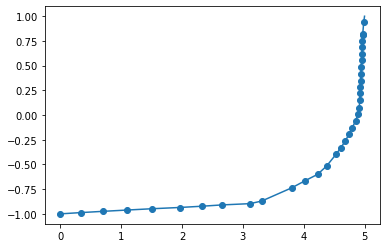

In [15]:
import matplotlib.pyplot as plt
X_test = np.array([[0, 0.341068, 0.711284, 1.10166, 1.5022, 1.96296, 2.333796, 2.65471, 3.115976, 3.3076, 3.806539, 4.0218, 4.22704, 4.374075, 4.533206, 4.608424, 4.684245, 4.7395, 4.795328, 4.850788, 4.886517, 4.911661, 4.917864, 4.922744, 4.927117, 4.931947, 4.93726, 4.94209, 4.947403, 4.952233, 4.957546, 4.961832, 4.966274, 4.9676, 4.984792]])
X_test= X_test.T


dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)


plt.plot(t_stress , RCS)
plt.scatter(X_test, activation3.output)
plt.show()

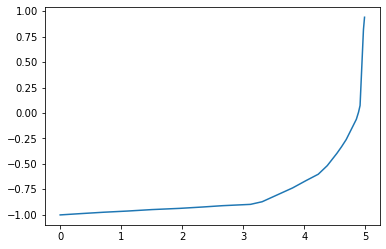

In [9]:
plt.plot(X_test, activation3.output)
plt.show()

In [13]:
print(dense1.weights)

print(dense1.biases)

[[ 0.11743062 -0.74679992  0.07371028  0.02799866 -0.11033476  0.30541289
  -0.17570517 -1.6690651  -0.01236116 -0.00426588 -0.31253478  1.4157439
   0.38301032  0.03209602 -1.7891768   0.23604372 -0.12250347 -1.07140273
   0.62336055 -0.93715111 -0.04705507 -0.01767849 -0.49705115 -0.54870924
  -0.46093587  0.11992082 -0.91920818 -1.4083953   0.12028607  0.01327958
   0.18669598 -0.27410277  0.61133429  0.17253484 -0.02415257  0.02644504
   0.07402898  0.16407178 -0.41996544  0.1371397  -0.07747418  0.08192433
   0.21926288  0.4607763  -1.5620725   0.09916721  0.07749121 -0.11308631
  -0.39640063 -0.60219412 -0.66139881 -0.30052601 -0.7618303  -1.78732674
  -0.06807973 -0.55290776 -0.6205891   0.35924247 -1.61505042 -0.53568397
  -0.46893533 -1.3250828   0.27738106  0.04481175]]
[[-0.64701476  0.         -0.4211518  -0.23625316 -0.12232749 -1.49964432
   0.          0.         -0.00454611 -0.05232631  0.         -0.64958857
  -1.41884287 -0.16222652  0.         -1.2248893  -0.18259478

In [11]:
print(dense2.weights)

[[-1.02971825 -0.39240409  0.06396068 ...  0.2733586   0.60860802
   1.40566609]
 [ 1.53718759 -1.93338272 -0.54704561 ... -0.47665304  1.22689819
   0.30674548]
 [-1.50180767  0.42531203  0.54718298 ... -0.4308807   0.31547891
  -3.28312228]
 ...
 [ 0.77362051 -0.91886738 -1.93049735 ... -1.55478147 -0.68571215
  -0.72646232]
 [ 0.24109972 -1.37358363  0.40798528 ...  0.33448723  0.50874488
   0.50523797]
 [-1.47457289 -1.34022339  0.11086903 ... -0.37420113 -0.43908747
   0.75166603]]


In [12]:
print(dense3.weights)

[[-1.12589805e-04]
 [-1.03153836e+00]
 [ 2.80555351e-02]
 [-8.53740893e-01]
 [ 7.59629564e-01]
 [-8.06648107e-01]
 [ 9.77172078e-01]
 [ 1.01908637e-01]
 [-6.67725678e-01]
 [ 3.83788876e-02]
 [ 8.55490032e-01]
 [-3.14577282e-03]
 [ 4.40181081e-02]
 [-4.42233485e-01]
 [-1.25056727e+00]
 [ 2.60232313e-01]
 [ 5.87062717e-01]
 [-1.32238771e-03]
 [ 1.43999892e+00]
 [ 2.22044185e-01]
 [ 3.07630472e-02]
 [ 4.15027666e-04]
 [ 7.82494424e-01]
 [ 5.30558160e-01]
 [ 1.36640396e-01]
 [-2.89398081e-06]
 [ 7.73258524e-01]
 [-7.38731347e-02]
 [ 4.27799538e-01]
 [ 1.11527472e-01]
 [ 3.10024809e-03]
 [-8.33499768e-01]
 [-1.44222052e-02]
 [ 3.25870120e-02]
 [ 4.32976372e-01]
 [ 3.29432648e-02]
 [ 4.84337157e-03]
 [-1.14283878e-02]
 [-7.19105011e-03]
 [ 6.66205327e-04]
 [-1.18483353e-01]
 [-8.46579091e-03]
 [-1.44894904e-05]
 [ 8.84809905e-02]
 [ 2.85336713e-01]
 [-1.51917534e+00]
 [ 2.10932517e-01]
 [ 6.98058298e-01]
 [ 5.10239655e-01]
 [-5.98698881e-05]
 [ 1.54800326e-01]
 [-1.16884740e+00]
 [-6.9714166

In [14]:

dense1.forward(2)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
activation2.forward(dense2.output)
dense3.forward(activation2.output)
activation3.forward(dense3.output)

print(activation3.output)

[[-0.93620774]]
